In [247]:
import os
import sys

import matplotlib.pyplot as plt
import cv2

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow import keras
from sklearn.cluster import KMeans
from math import ceil

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

In [249]:
np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline

# Model
Keras Xception https://keras.io/applications/#xception

In [250]:
model = keras.applications.xception.Xception(
    include_top=False, 
    weights='imagenet', 
    input_tensor=None, 
    input_shape=(224,224,3), 
    pooling='avg') #change with pooling to find better fit

In [251]:
# function for putting together a list of images from a given list of names and a directory
def createBatch(imgList, directory):
    im_batch = []
    for name in imgList:
        img = cv2.imread(directory + name)
        resize_img = cv2.cvtColor(cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC), cv2.COLOR_BGR2RGB)
        im_batch.append(resize_img)
    return im_batch

# Images

In [406]:
# directories of images
zerodir = "zerophotos/"
onedir = "onephotos/"
# list of names from each directory
zeroimages = os.listdir(zerodir)
oneimages = os.listdir(onedir)

# create the list of images pulled from each directory
zero_batch = createBatch(zeroimages, zerodir)
one_batch = createBatch(oneimages, onedir)

# combine the image batches into one list
im_batch = []
im_batch.extend(one_batch)
im_batch.extend(zero_batch)

im_batch_labels = [1] * len(one_batch)
im_batch_labels.extend([0] * len(zero_batch))


# convert to numpy array type
im_batch = np.array(im_batch)

print(im_batch.shape)

(1643, 224, 224, 3)


# Predictions

In [253]:
predictions = model.predict(im_batch, verbose=1)
print(predictions.shape) 

1643/1643 [==============================] - 253s 154ms/sample
(1643, 2048)


# Calculate Clusters

In [372]:
kmeans = KMeans(n_clusters=50, random_state=0).fit(predictions)
# kmeans predictions
kmeans_p = kmeans.predict(predictions)
# find the centers
centers = kmeans.cluster_centers_

# Plot Clusters

In [373]:
# fit predictions to a size that can be plotted in 2D
predictions_fit = TSNE(n_components=2, perplexity=30).fit_transform(predictions)

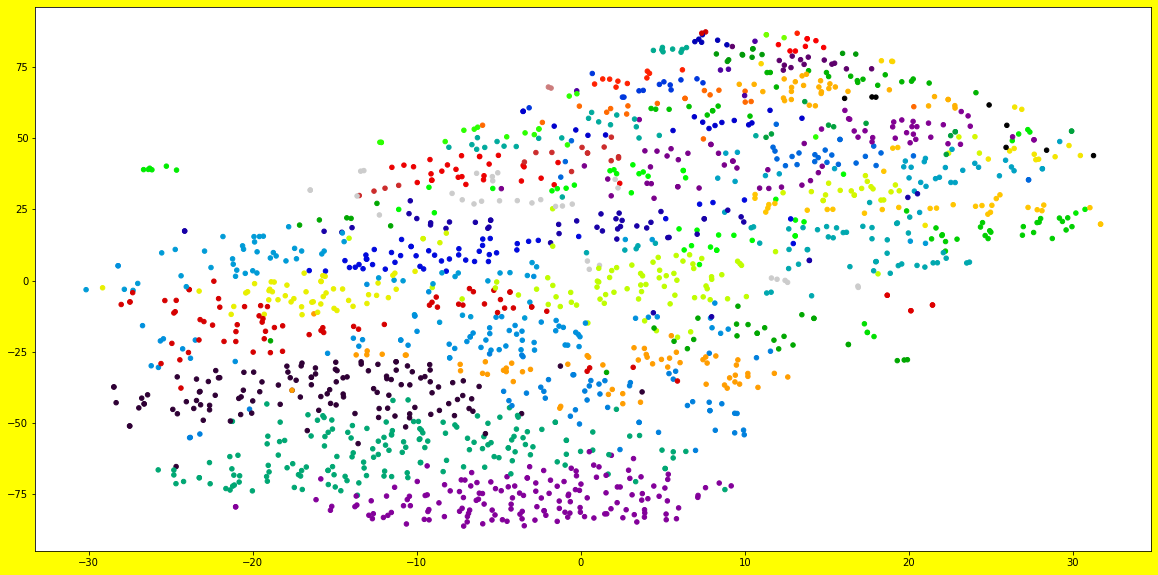

In [374]:
# Set the x and y coordinates
x2D = predictions_fit[:, 0]
y2D = predictions_fit[:, 1]

fig2D = plt.figure(figsize=(20, 10), facecolor='yellow')
scatter2D = fig2D.add_subplot(111)

# plot scatter plot
scatter2D.scatter(x2D, y2D, c=kmeans_p, s=20, cmap='nipy_spectral')
#plt.scatter(centers[:, 0], centers[:, 1], c="blue", s=100, alpha=0.5)
plt.show()

In [375]:
plt.close() # close the 2D plot

In [376]:
# fit predictions to a size that can be plotted in 3D
predictions_fit_3D = TSNE(n_components=3, perplexity=500).fit_transform(predictions)

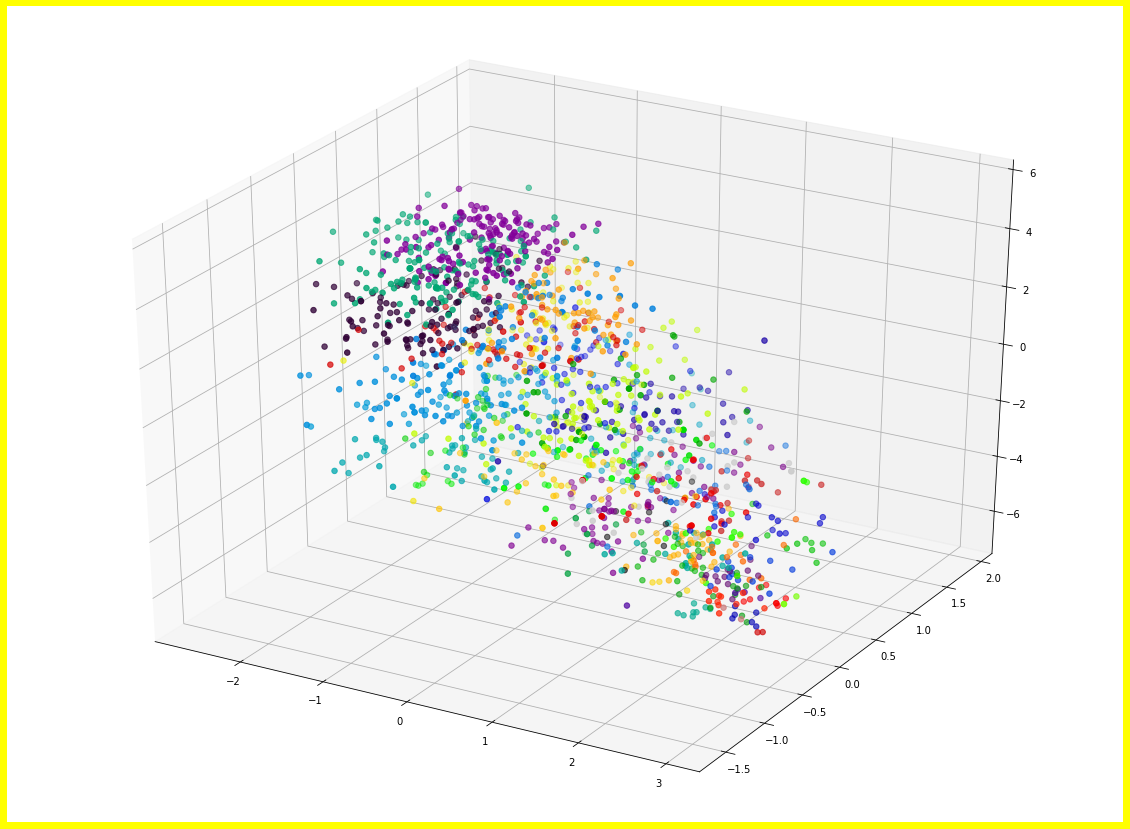

In [377]:
# create 3D plot
fig3D = plt.figure(figsize=(20, 15), facecolor="yellow")
scatter3D = fig3D.add_subplot(111, projection='3d')

# set the coordinates
x3D, y3D, z3D = predictions_fit_3D[:,0], predictions_fit_3D[:,1], predictions_fit_3D[:,2]

scatter3D.scatter(x3D, y3D, z3D, c=kmeans_p, s=30, cmap='nipy_spectral', marker='o')
plt.show()

In [378]:
plt.close() # close the 3D plot

In [379]:
# create interactive figure and plot scatter
#fig = plt.figure()
#interactive2D = fig.add_subplot(111)
#lines, = interactive2D.scatter(x2D, y2D, marker='o')
#points = interactive2D.collections[0].get_offsets()

# create the annotations box
#im = OffsetImage(im_batch[0,:,:,:], zoom=5)
#xybox=(50., 50.)
#ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
        #boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
# add it to the axes and make it invisible
#interactive2D.add_artist(ab)
#ab.set_visible(False)

#def hover(event):
    # if the mouse is over the scatter points
    #if line.contains(event)[0]:
        # find out the index within the array from the event
        #ind, = line.contains(event)[1]["ind"]
        # get the figure size
        #w,h = fig.get_size_inches()*fig.dpi
        #ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
        #hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
        # if event occurs in the top or right quadrant of the figure,
        # change the annotation box position relative to mouse.
        #ab.xybox = (xybox[0]*ws, xybox[1]*hs)
        # make annotation box visible
        #ab.set_visible(True)
        # place it at the position of the hovered scatter point
        #ab.xy =(x[ind], y[ind])
        # set the image corresponding to that point
        #im.set_data(img_batch[ind,:,:,:])
    #else:
        #if the mouse is not over a scatter point
        #ab.set_visible(False)
    #fig.canvas.draw_idle()

# add callback for mouse moves
#fig.canvas.mpl_connect('motion_notify_event', hover)
#plt.show()

# Analyze Clusters

In [407]:
# create a dictionary to hold the indices which correspond to each label
indices = {}
for i in range(0, len(predictions)):
    if kmeans.labels_[i] in indices:
        indices[kmeans.labels_[i]].extend([i])
    else:
        indices[kmeans.labels_[i]] = [i]

In [443]:
# calculate the average score of each label
def avgScore(listOfPos, labels):
    average = 0
    for i in range(0, len(listOfPos)):
        average += labels[listOfPos[i]]
    return average / len(listOfPos)

def getHighScores(averageScores, bound):
    highClusters = []
    for cluster in averageScores:
        if averageScores[cluster] >= bound:
            highClusters.append(cluster)
    return highClusters

def getLowScores(averageScores, bound):
    lowClusters = []
    for cluster in averageScores:
        if averageScores[cluster] <= bound:
            lowClusters.append(cluster)
    return lowClusters

def printScore(averageScores, cluster):
    print("Cluster", cluster, "has a score of", averageScores[cluster])
    return

def printHighScores(averageScores, bound):
    highScore = getHighScore(averageScores, bound)
    for cluster in highScore:
        printScore(averageScores, cluster)
    return

def printLowScores(averageScores, bound):
    lowScore = getLowScore(averageScores, bound)
    for cluster in lowScore:
        printScore(averageScores, cluster)
    return

averageScores = {}
for index in range(0, len(indices.keys())):
    averageScores[index] = avgScore(indices[index], im_batch_labels)
    #print("The score of cluster", index, "is", averageScores[index])

In [444]:
printHighScores(averageScores, 0.60)

Cluster 17 has a score of 0.62
Cluster 25 has a score of 0.7777777777777778
Cluster 30 has a score of 0.625
Cluster 33 has a score of 0.6071428571428571
Cluster 46 has a score of 1.0


In [445]:
printLowScores(averageScores, 0.30)

Cluster 5 has a score of 0.2922077922077922
Cluster 13 has a score of 0.22641509433962265
Cluster 18 has a score of 0.2857142857142857
Cluster 21 has a score of 0.25
Cluster 27 has a score of 0.25
Cluster 32 has a score of 0.2777777777777778
Cluster 36 has a score of 0.25
Cluster 37 has a score of 0.1875
Cluster 39 has a score of 0.26229508196721313
Cluster 41 has a score of 0.18181818181818182
Cluster 42 has a score of 0.125
Cluster 43 has a score of 0.2857142857142857
Cluster 44 has a score of 0.0


In [446]:
def printCounts(listOfPos, labels):
    scores = {0: 0, 1: 0}
    for i in range(0, len(listOfPos)):
        scores[labels[listOfPos[i]]] += 1
    print("# of zeros:", scores[0])
    print("# of ones:", scores[1])
    return
  
def printClusterCounts(cluster):
    print("Cluster", cluster, "image scores")
    printCounts(indices[cluster], im_batch_labels)

In [447]:
high = getHighScores(averageScores, 0.60)
for score in high:
    printClusterCounts(score)

Cluster 17 image scores
# of zeros: 19
# of ones: 31
Cluster 25 image scores
# of zeros: 2
# of ones: 7
Cluster 30 image scores
# of zeros: 6
# of ones: 10
Cluster 33 image scores
# of zeros: 11
# of ones: 17
Cluster 46 image scores
# of zeros: 0
# of ones: 2


In [448]:
low = getLowScores(averageScores, 0.3)
for score in low:
    printClusterCounts(score)

Cluster 5 image scores
# of zeros: 109
# of ones: 45
Cluster 13 image scores
# of zeros: 41
# of ones: 12
Cluster 18 image scores
# of zeros: 15
# of ones: 6
Cluster 21 image scores
# of zeros: 9
# of ones: 3
Cluster 27 image scores
# of zeros: 3
# of ones: 1
Cluster 32 image scores
# of zeros: 52
# of ones: 20
Cluster 36 image scores
# of zeros: 3
# of ones: 1
Cluster 37 image scores
# of zeros: 26
# of ones: 6
Cluster 39 image scores
# of zeros: 45
# of ones: 16
Cluster 41 image scores
# of zeros: 9
# of ones: 2
Cluster 42 image scores
# of zeros: 7
# of ones: 1
Cluster 43 image scores
# of zeros: 20
# of ones: 8
Cluster 44 image scores
# of zeros: 6
# of ones: 0


In [449]:
def pltPics(maxAmount, cluster):
    plt.figure(figsize=(20, maxAmount*0.75))
    plt.subplots_adjust(hspace=0.7, wspace=1)
    for i in range(0, min(len(indices[cluster]), maxAmount)):
        plt.subplot(ceil(maxAmount/5), 5, i+1)
        index = indices[cluster][i]
        plt.imshow(im_batch[index])
        plt.title(im_batch_labels[index])
        plt.axis('off')

Cluster 30 has a score of 0.625


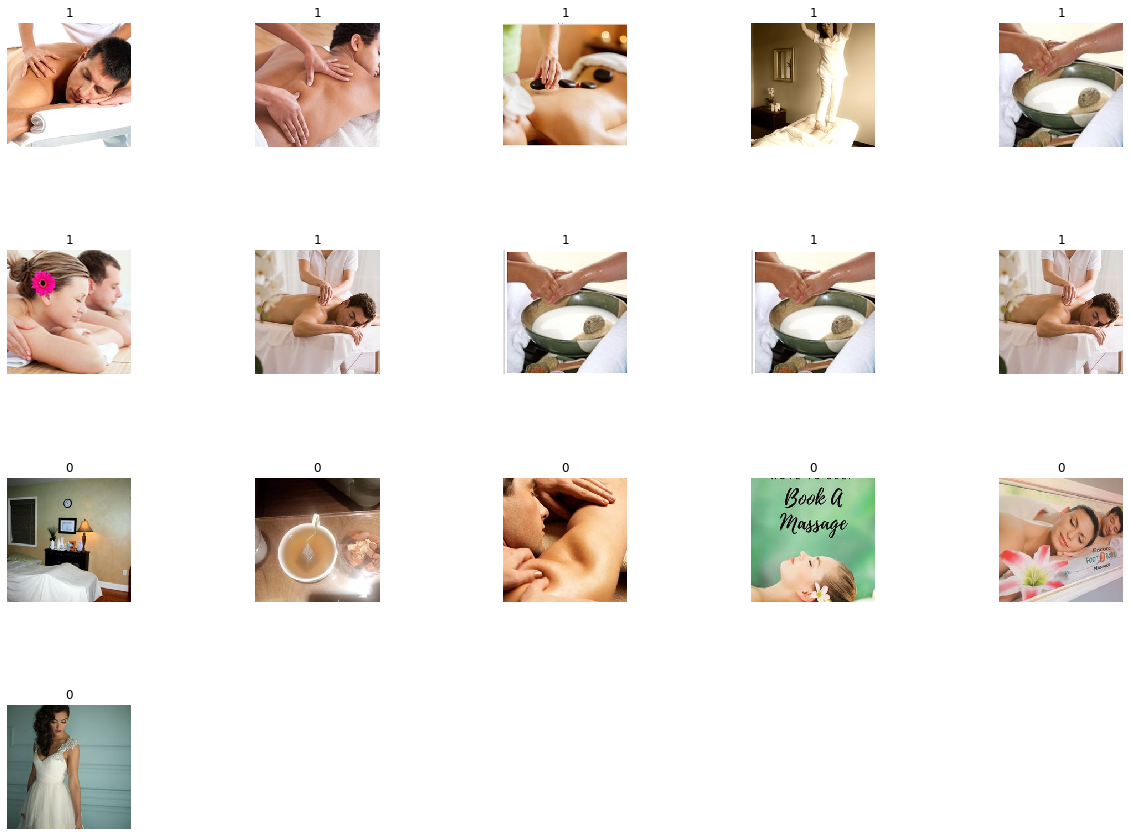

In [450]:
# cluster 30
printScore(averageScores, 30)
pltPics(20, 30)

Cluster 17 has a score of 0.62


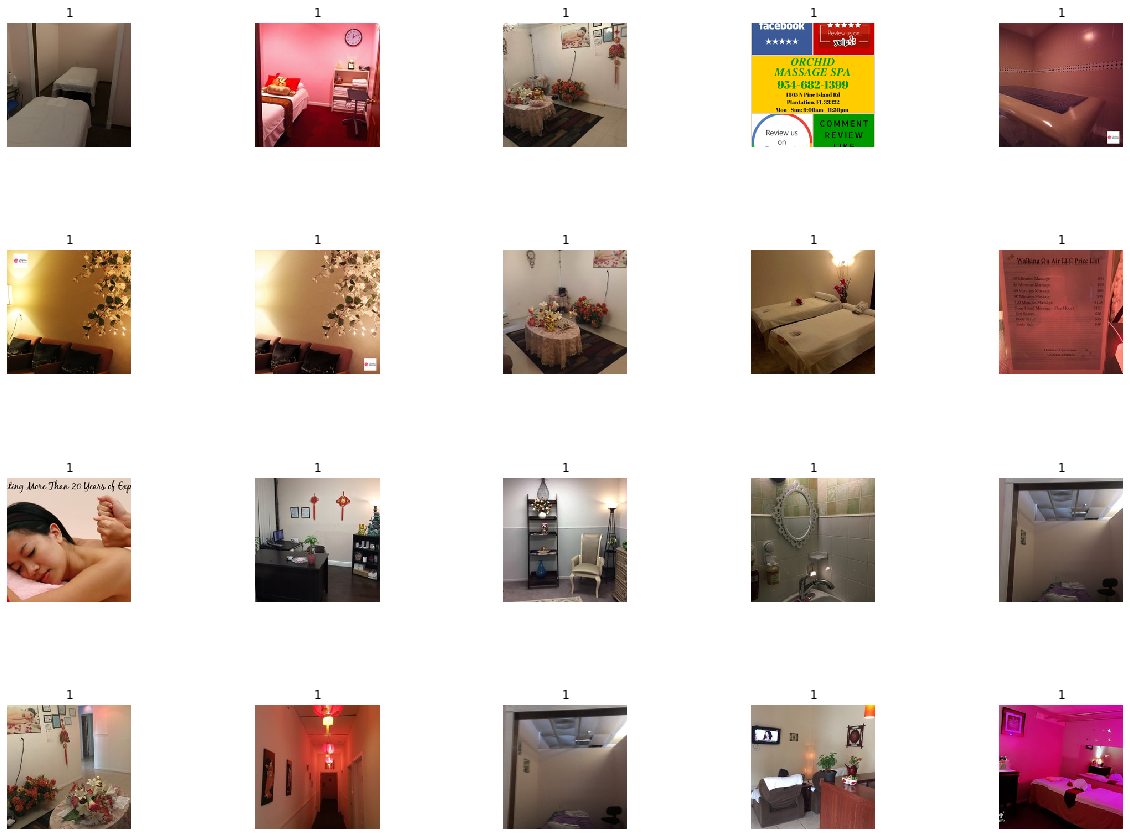

In [451]:
# cluster 17
printScore(averageScores, 17)
pltPics(20, 17)

Cluster 8 has a score of 0.5


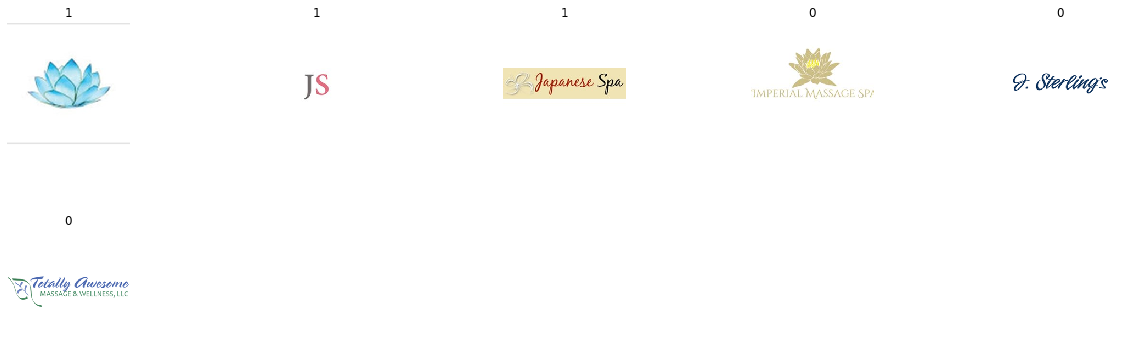

In [459]:
# cluster 8
printScore(averageScores, 8)
pltPics(100, 8)

Cluster 10 has a score of 0.40816326530612246


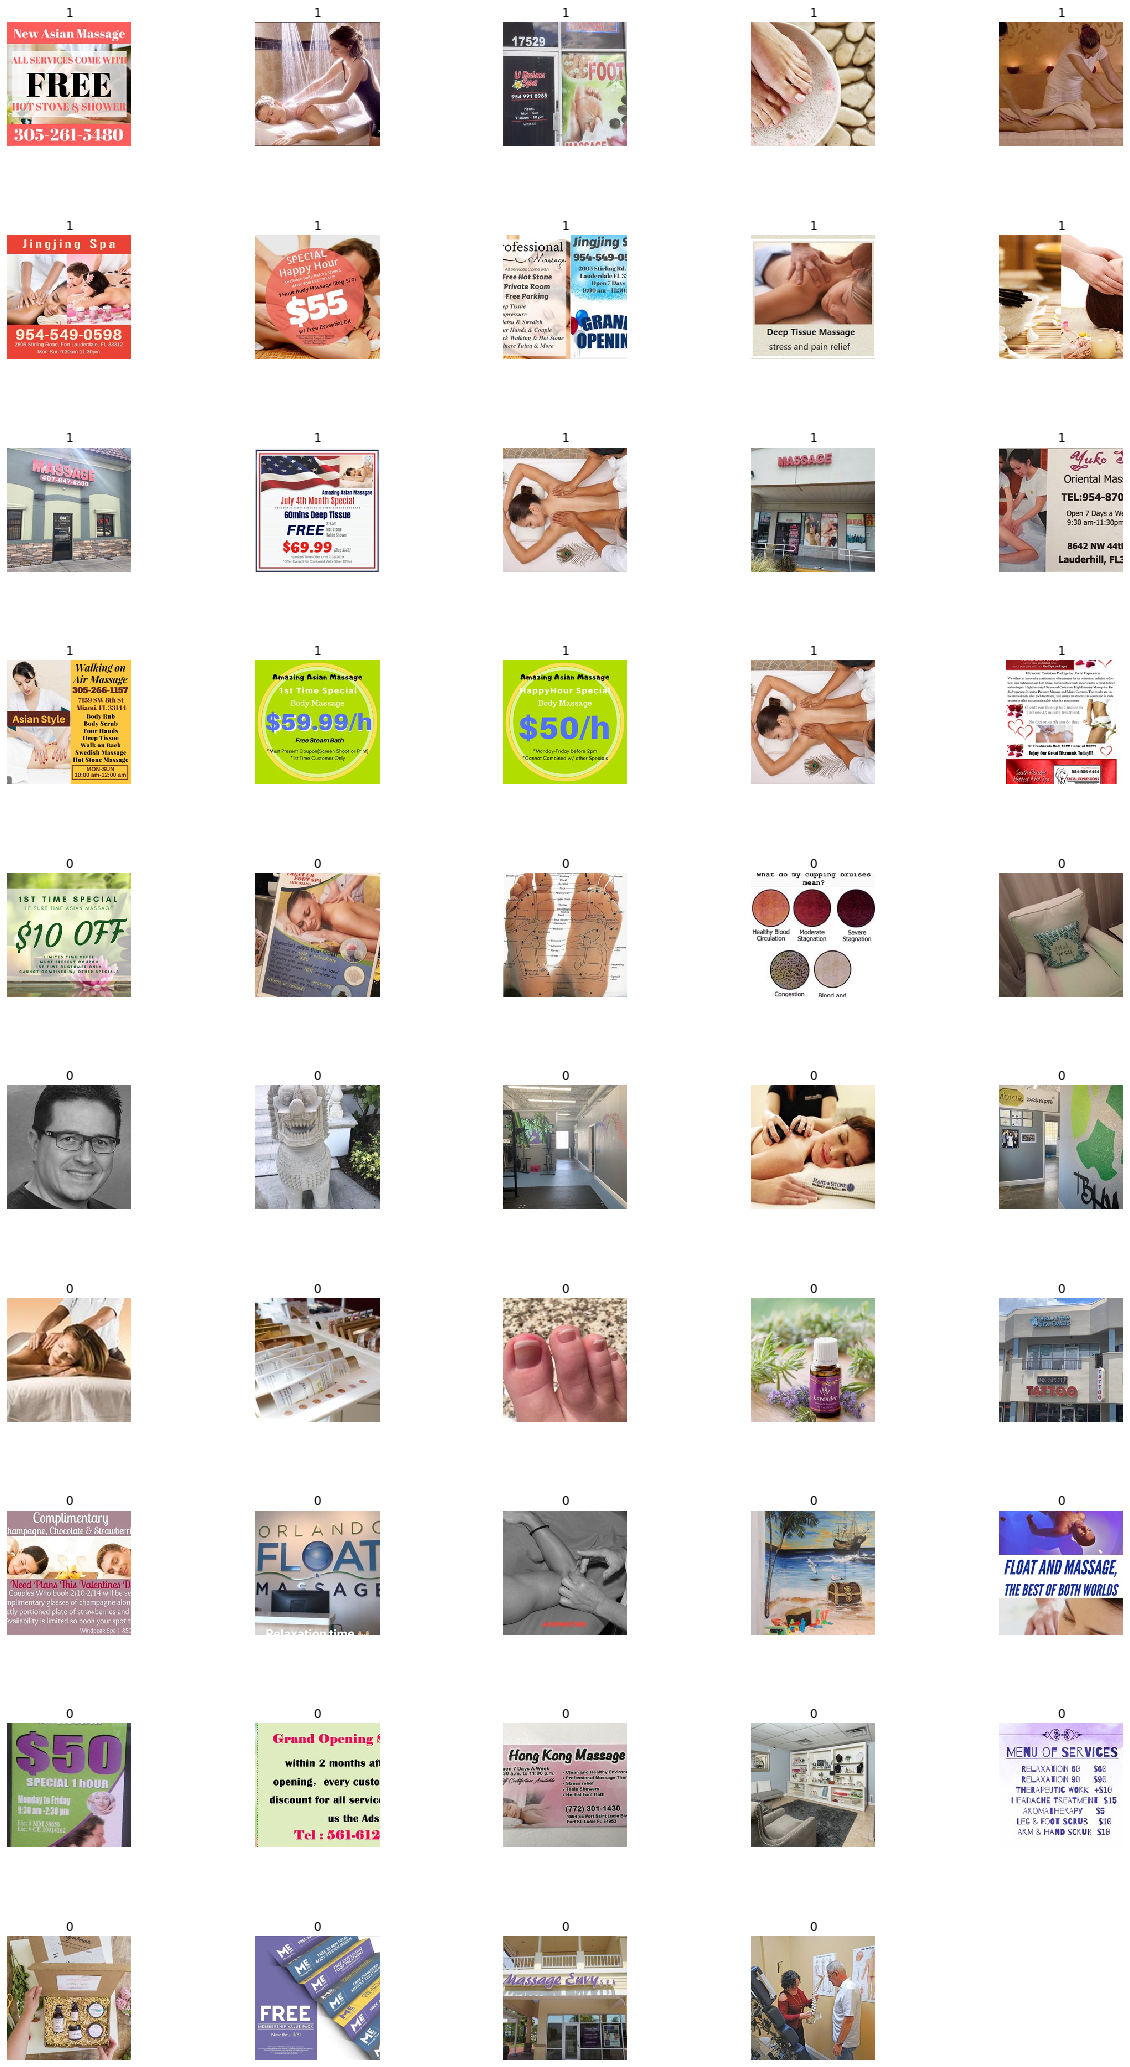

In [462]:
# cluster 10
printScore(averageScores, 10)
pltPics(50, 10)

Cluster 19 has a score of 0.375


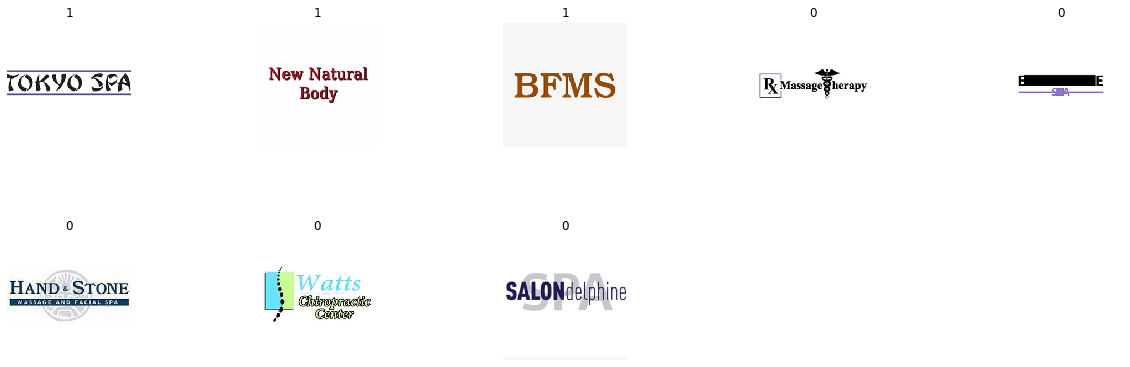

In [471]:
# cluster 19
printScore(averageScores, 19)
pltPics(50, 19)

Cluster 21 has a score of 0.25


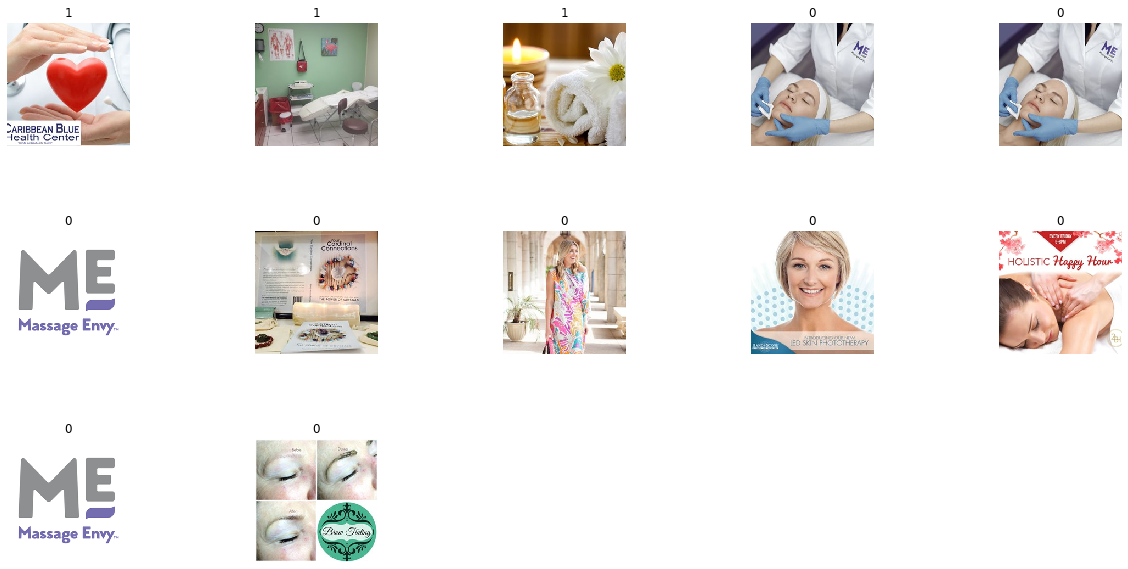

In [474]:
# cluster 21
printScore(averageScores, 21)
pltPics(100, 21)

Cluster 23 has a score of 0.34375


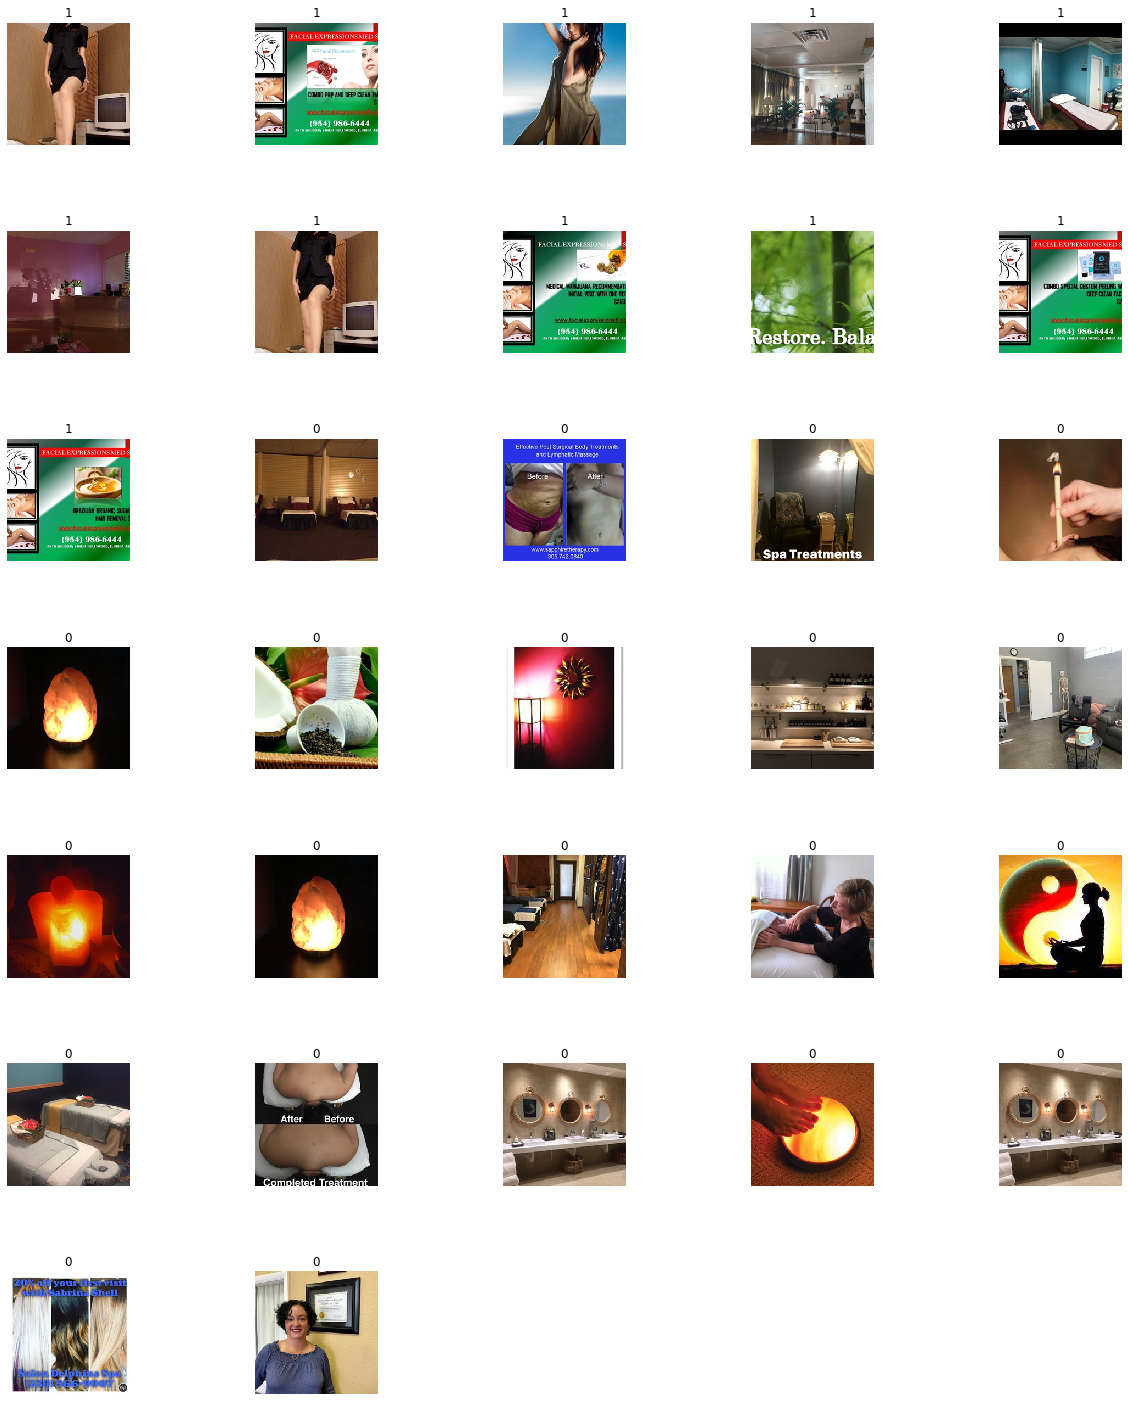

In [476]:
# cluster 23
printScore(averageScores, 23)
pltPics(100, 23)

Cluster 26 has a score of 0.34615384615384615


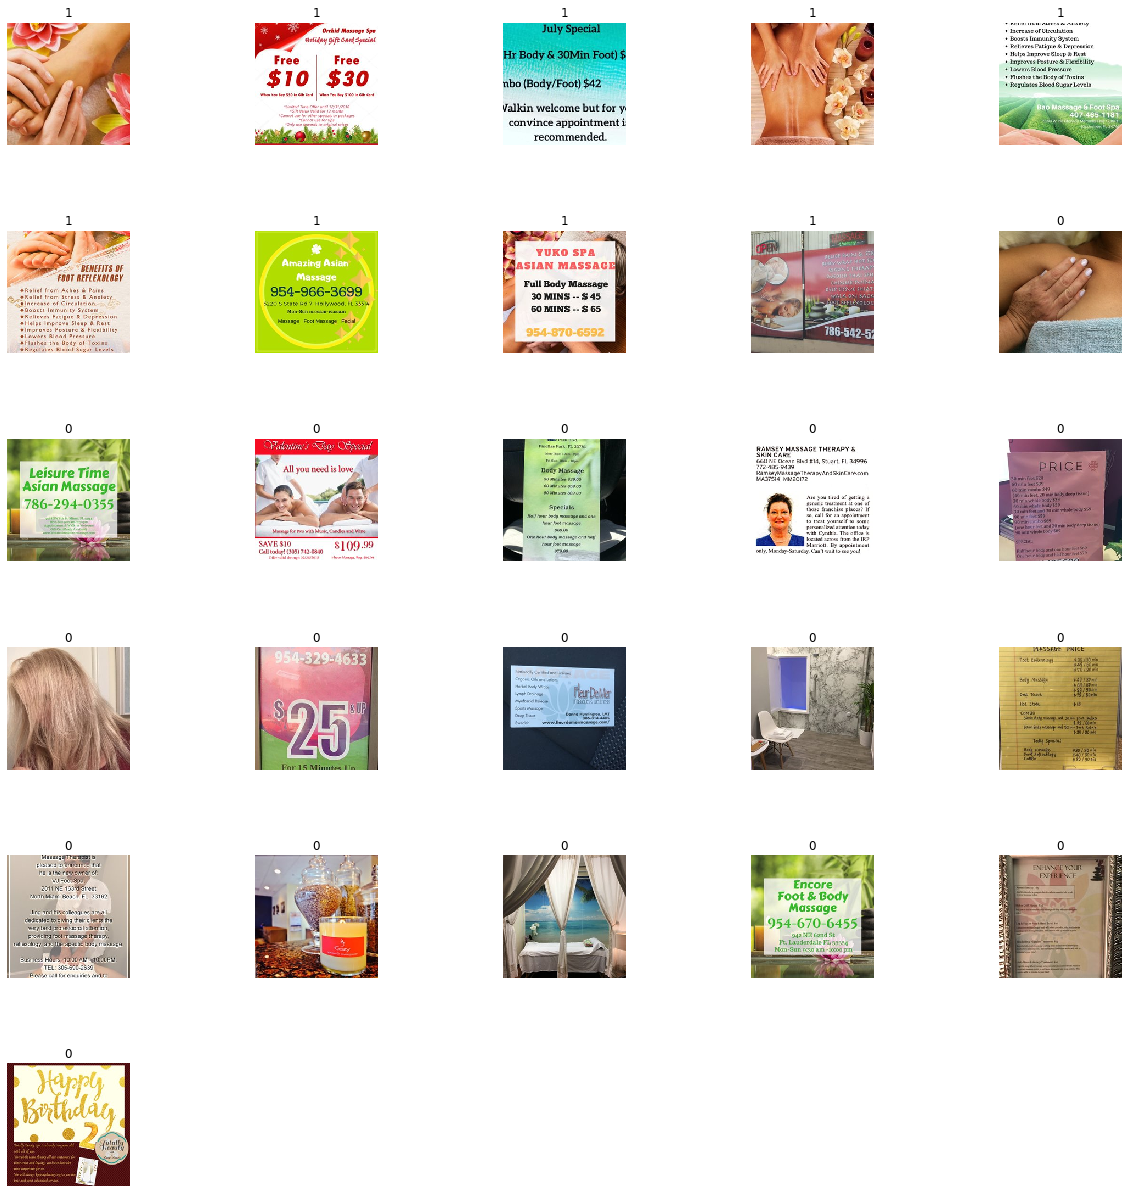

In [479]:
# cluster 26
printScore(averageScores, 26)
pltPics(100, 26)

Cluster 27 has a score of 0.25


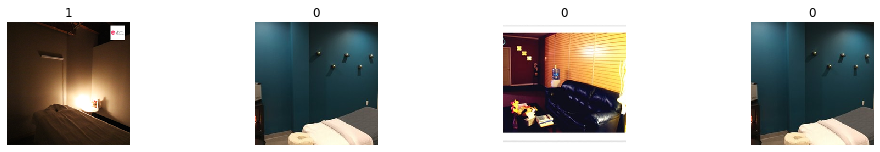

In [480]:
# cluster 27
printScore(averageScores, 27)
pltPics(100, 27)

Cluster 28 has a score of 0.5833333333333334


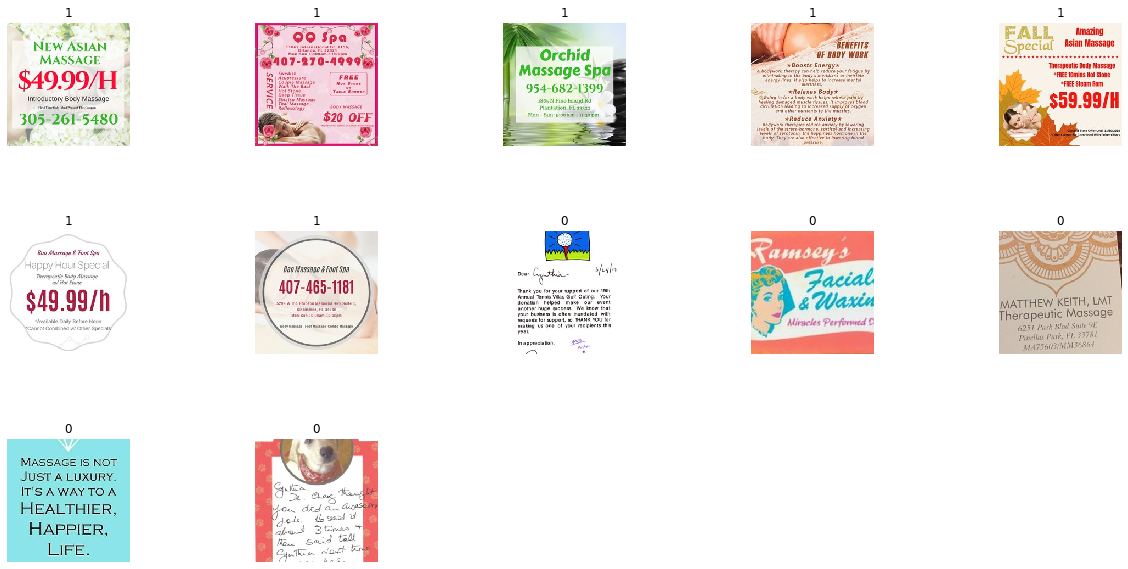

In [481]:
# cluster 28
printScore(averageScores, 28)
pltPics(100, 28)